# Phase-vocoder

References:

https://www.guitarpitchshifter.com/algorithm.html

https://cmtext.indiana.edu/synthesis/chapter4_pv.php

https://cycling74.com/tutorials/the-phase-vocoder-%E2%80%93-part-i

https://librosa.org/doc/latest/index.html

## Задача

Есть цифровой сигнал звука. Мы хотим сжать/растянуть его по времени. Если сделать это наивно, просто удалив или интерполирововав промежуточные значения в цифровом сигнале, у звука изменится частота и соответственно высота - он будет звучать либо более высоким при сжатии, либо более низким при растяжении. 

Мы же хотим сохранить питч, поэтому в статье предлагается следующая идея - пройтись окном (aka свертка) по сигналу, сам сигнал растянуть, а затем просуммировать со сглаженной суммой всех окон, причем относительное положение окон меняется, чтобы совпасть с длинной сигнала.


![](https://www.guitarpitchshifter.com/fig_3_3.png)

Однако возникает проблема, связанная с сильными различиями звука на стыке окон, что станет причиной возникновения слышимых звуковых гличей.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import numba

from IPython.display import Audio
from IPython.display import display

In [4]:
INPUT_FILE = './data/test_mono.wav'
OUTPUT_FILE = './data/test_mono_out.wav'

# SIGNAL PARAMETERS
SAMPLING_RATE = 16000
BITRATE = 256
TIME_DURATION = 16

# AUDIO PROCESSING PARAMETERS
WINDOW_SIZE = 512
HOP_SIZE_A = WINDOW_SIZE // 4

In [13]:
!ffprobe -hide_banner -i $INPUT_FILE # check sampling rate and other parameters

Input #0, wav, from './data/test_mono.wav':
  Metadata:
    artist          : Sound Clip
    date            : 2018
    genre           : Sound Clip
    title           : Sound_08129
    album           : Речи, обращения
    encoder         : Lavf58.29.100
  Duration: 00:00:16.80, bitrate: 256 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, 1 channels, s16, 256 kb/s


In [9]:
def wav_to_mel_spectrogram(wav, sr, n_fft, hop_length, n_mels):
    D = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)
    S = librosa.feature.melspectrogram(S=np.abs(D), sr=sr, n_mels=n_mels)
    return S

In [10]:
# write a function to plot mel spectrogram
def plot_mel_spectrogram(mel_spectrogram, sr, hop_length, n_mels):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                             y_axis='mel', fmax=sr/2, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

In [21]:
def display_sound(data, plot=False):
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(data)
        plt.title('График амплитуд')
        plt.tight_layout()
        plt.show()
    display(Audio(data, rate=SAMPLING_RATE))

In [22]:
data, sr = librosa.load(INPUT_FILE, sr=16000)
display_sound(data)

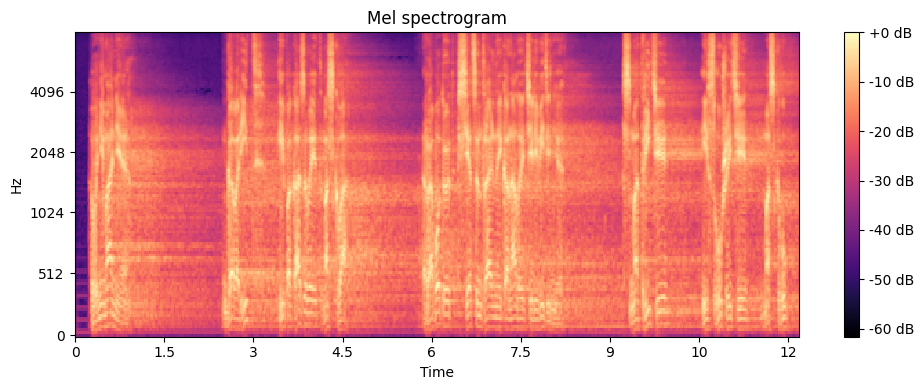

In [18]:
n_fft = 2048
hop_length = 512
n_mels = 128
mel_spectrogram = wav_to_mel_spectrogram(data, SAMPLING_RATE, n_fft, hop_length, n_mels)
plot_mel_spectrogram(mel_spectrogram, sr, hop_length, n_mels)

## Решение

In [7]:
from math import cos, pi
import scipy.fft as spft

def hanning_window(n, N):
    w = 0.5 * (1 - cos(2*pi*n / N))
    return w

def stft(x: np.ndarray, sr:int,  N: int, hop_size: int) -> np.ndarray:
    """Performs STFT by applying Hanning window
    
    ## Parameters:
    - `x: np.ndarray` - source digital signal
    - `sr: int` - sampling rate of signal
    - `frame_size: int` - size of single frame (frame_size assumed to be equal to window_size)
    - `hop_size: int` - size of hop between frames, 1/hop_size = overlap
    - `N: int` - size of Hammon window

    ## Returns:
    - `X: np.ndarray` - freq_bins/frames matrix
    - `freqs: np.ndarray` - array of frequencies per each freq_bin
    """
    freq_bins = int(N // 2 + 1) # -> (0, sr/2)Hz range
    frames = (len(x) - N) // hop_size + 1 
    X = np.zeros((freq_bins, frames), dtype='complex_')
    w = np.array([hanning_window(n, N) for n in range(N)]) # precalculated hanning window function values
    for i in range(frames):
        frame = x[i*hop_size:i*hop_size + N] * w
        X[:, i] = spft.fft(frame, N)[:freq_bins]
    return X

In [19]:
X = stft(data, SAMPLING_RATE, WINDOW_SIZE, HOP_SIZE_A)

In [14]:
def processing(x: np.ndarray, sr: int) -> np.ndarray:
    """Obtaining true frequencies and adjusting phase
    ## Parameters:
    - `X: np.ndarray` - freq_bins/frames matrix
    - `sr: int` - sampling rate of original signal

    ## Returns:
    `X_s: np.ndarray` - freq_bins/frames matrix

    """
    # calculate phases and frequencies
    X_s = np.zeros(X.shape, dtype='complex_')
    
    for i in range(X.shape[1]):
        pass
    return X_s
    

In [34]:
from typing import Union

def synthesis(X: np.ndarray, n: int, sr: int, N: int, hs_a: int, r: Union[float, int]) -> np.ndarray:
    """Apply ifft to each frame with hanning window and add overlapping windows
    
    ## Parameters:
    - `X: np.ndarray` - freq_bins/frames matrix
    - `n: int` - number of samples in original signal
    - `sr: int` - sampling rate of original signal
    - `N: int` - size of Hammon window
    - `hs_a: int` - size of hop between frames during analysis phase
    - `r: Union[float, int]` - stretch ratio 

    ## Returns:
    `y: np.ndarray` - synthesized signal (stretched or compressed without changed pitch)
    """
    new_n = int(n * r)
    hs = hs_a * (new_n - N) // (n - N)

    q = np.zeros((X.shape[1], new_n))
    y = np.zeros(new_n)
    w = np.array([hanning_window(n, N) for n in range(N)]) # precalculated hanning window function values
    for i in range(X.shape[1]):
        q[i, i*hs:i*hs + N] = np.real(spft.ifft(X[:, i], N)) * w
    
    # add overlapping windows
    for i in range(X.shape[1]):
        y[i*hs:i*hs + N] += q[i, i*hs:i*hs + N]
    return y


In [35]:
# generate short signal for testing
x = np.sin(2 * np.pi * 440 * np.arange(0, 1, 1/SAMPLING_RATE))
X = stft(x, SAMPLING_RATE, WINDOW_SIZE, HOP_SIZE_A)
y = synthesis(X, len(x), SAMPLING_RATE, WINDOW_SIZE, HOP_SIZE_A, 0.5)
display_sound(x)
display_sound(y)

In [37]:
X = stft(data, SAMPLING_RATE, WINDOW_SIZE, HOP_SIZE_A)
y = synthesis(X, len(data), SAMPLING_RATE, WINDOW_SIZE, HOP_SIZE_A, 0.5)
display_sound(data)
display_sound(y)